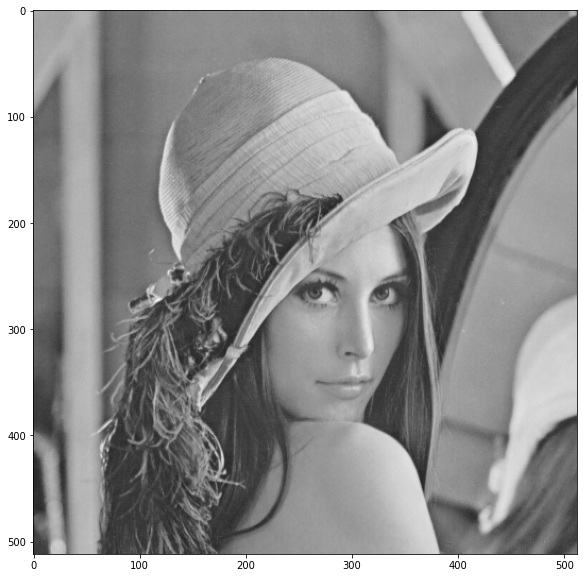

In [4]:
import math
import glob
import copy

import cv2
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

img = cv2.imread('images/lenna.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))

from tqdm.auto import tqdm
from pylab import rcParams

# Детектор: FAST

Implementation of FAST Algorithm for Corner Detection with Non-maximal Suppression

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_fast/py_fast.html

In [5]:
THRESHOLD = 30
NON_MAX_SUPPRESSION_DIST = 4
N = 12

def get_circle_elements(A,x,y):
    points = []
    points.append(A[x-3, y])
    points.append(A[x-3, y+1])
    points.append(A[x-2, y+2])
    points.append(A[x-1, y+3])
    points.append(A[x, y+3])
    points.append(A[x+1, y+3])
    points.append(A[x+2, y+2])
    points.append(A[x+3, y+1])
    points.append(A[x+3, y])
    points.append(A[x+3, y-1])
    points.append(A[x+2, y-2])
    points.append(A[x+1, y-3])
    points.append(A[x, y-3])
    points.append(A[x-1, y-3])
    points.append(A[x-2, y-2])
    points.append(A[x-3, y-1])
    return points

def check_point(p,c,t = THRESHOLD):
    """
    Used to check if the point is brighter or darker then other with given THRESHOLD
    """
    if c<=p-t:
        return 1
    elif p+t<=c:
        return 2
    else:
        return 0

def check_subset_one(x):
    """
    Used to find contiguous pixels sets in the circle (of 16 pixels) 
    which are all brighter, or all darker than given pixel
    """
    subset = 0
    sets = []
    starts_with_one = x[0]==1
    
    for i in x:
        if i==1:
            subset+=1
        else:
            sets.append(subset)
            subset = 0
            
    # add last element if exist
    sets.append(subset)
    
    # take into account the fact that we are working with circle
    if starts_with_one and len(sets)>1:
        sets[0] = sets[0]+sets[-1]
        sets = sets[:-1]
        
    return [i for i in sets if i>=N]

def check_subset(x):
    """
    Used to find contiguous pixels sets in the circle (of 16 pixels) 
    which are all brighter, or all darker than given pixel.
    Check subarrays of brighter and darker elements separately
    """
    a = (np.array(x)==1).astype(int)
    b = (np.array(x)==2).astype(int)
    return check_subset_one(a) + check_subset_one(b)
    
def areAdjacent(point1, point2):
    """
    Identifies if two points are adjacent by calculating distance in terms of rows/cols
    Two points are adjacent if they are within four pixels of each other (Euclidean distance)
    """
    row1, col1 = point1
    row2, col2 = point2
    xDist = row1 - row2
    yDist = col1 - col2
    return (xDist ** 2 + yDist ** 2) ** 0.5 <= NON_MAX_SUPPRESSION_DIST

def suppress(image, corners, scores):
    """
    Performs non-maximal suppression on the list of corners.
    For adjacent corners, discard the one with the smallest score.
    Otherwise do nothing
    """
    i = 1
    while i < len(corners):
        currPoint = corners[i]
        prevPoint = corners[i - 1]
        if areAdjacent(prevPoint, currPoint):
            currScore = scores[currPoint]
            prevScore = scores[prevPoint]
            if (currScore > prevScore):
                del(corners[i - 1])
            else:
                del(corners[i])
        else:
            i += 1
            continue
    return

def fast(img):
    """
    Identify corner points. FAST itself
    """
    a,b = img.shape
    corner_points = []
    scores = np.zeros((a,b))

    for i in tqdm(range(3,a-3)):
        for j in range(3,b-3):
            p = img[i,j]
            circle = get_circle_elements(img,i,j)
            tmp = check_subset([check_point(p,c) for c in circle])
            if len(tmp)>0:
                corner_points.append((i,j)) 
            scores[i,j] = np.sum([abs(p - i_c) for i_c in circle])

    suppress(img, corner_points, scores)
    return corner_points
    

/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in ubyte_scalars



Number of corner points:  392


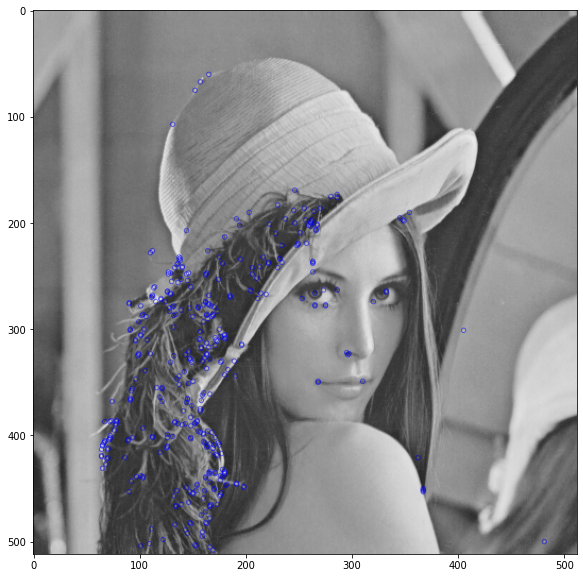

In [6]:
corner_points = fast(img)
corner_points = [list(c) for c in corner_points] # for plotting
rcParams['figure.figsize'] = 10, 10
print('Number of corner points: ', len(corner_points))
plt.imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))
plt.scatter(np.array(corner_points)[:,1], np.array(corner_points)[:,0], s = 20, alpha=0.5, edgecolors='b', color = 'none')
plt.show()

### Порівняти і описати як впливає попереднє розмивання зображення (конволюція із гаусіаною) на знаходження фіч.
**Коментар:** Як можна бачити з наступного малюнку попереднє розмивання значно знижує кількість знайдених кутових точок (точок, що рахуються фічами). Знаходиться менше фіч ніж в аналогічному зображенні без розмиття при запуску алгоритму з аналогічними константами. Набагато менше фіч в області волосся. Суб'єктивна оцінка - алгоритм значно гірше відпрацьовує. 

/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in ubyte_scalars



Number of corner points:  121


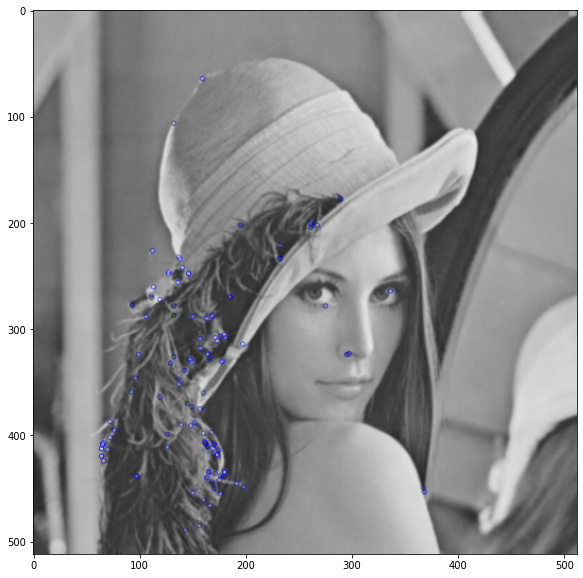

In [10]:
blur = cv2.GaussianBlur(img,(3,3),0)
corner_points = fast(blur)
corner_points = [list(c) for c in corner_points] # for plotting
rcParams['figure.figsize'] = 10, 10
print('Number of corner points: ', len(corner_points))
plt.imshow(cv2.cvtColor(blur, cv2.IMREAD_GRAYSCALE))
plt.scatter(np.array(corner_points)[:,1], np.array(corner_points)[:,0], s = 20, alpha=0.5, edgecolors='b', color = 'none')
plt.show()

### Порівняти і описати як впливає зменшення зображення із ефектом sampling і без нього. Зображення зменшити як мінімум у 8 раз по одній осі (якщо розмір 512x512, то розмір зменшеного зображення заксимум - 64x64)

- Зменшення зображення із ефектом sampling:


Number of corner points:  67


/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in ubyte_scalars


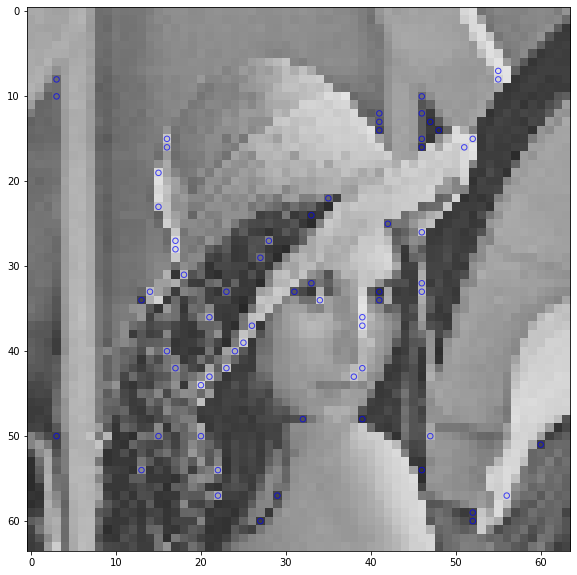

In [8]:
img_1 = cv2.resize(img, interpolation=cv2.INTER_NEAREST, dsize = (int(img.shape[0]/8),int(img.shape[1]/8)))
corner_points = fast(img_1)
corner_points = [list(c) for c in corner_points] # for plotting
rcParams['figure.figsize'] = 10, 10
print('Number of corner points: ', len(corner_points))
plt.imshow(cv2.cvtColor(img_1, cv2.IMREAD_GRAYSCALE))
plt.scatter(np.array(corner_points)[:,1], np.array(corner_points)[:,0], s = 30, alpha=0.7, edgecolors='b', color = 'none')
plt.show()

- Зменшення зображення без ефектом sampling:

/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in ubyte_scalars



Number of corner points:  25


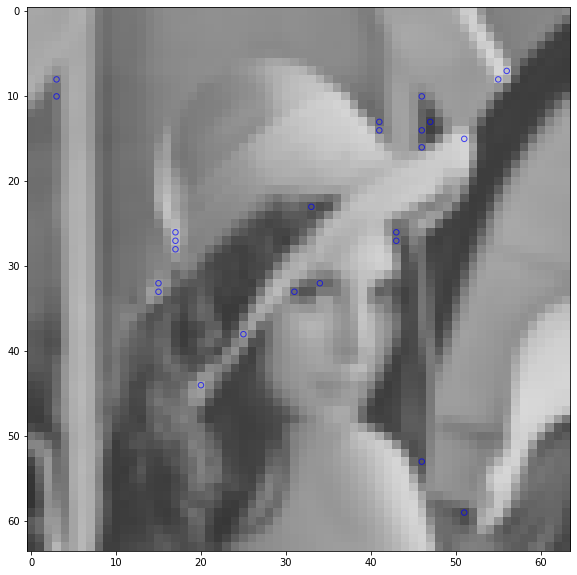

In [9]:
img_2 = cv2.pyrDown(cv2.pyrDown(cv2.pyrDown(img)))
corner_points = fast(img_2)
corner_points = [list(c) for c in corner_points] # for plotting
rcParams['figure.figsize'] = 10, 10
print('Number of corner points: ', len(corner_points))
plt.imshow(cv2.cvtColor(img_2, cv2.IMREAD_GRAYSCALE))
plt.scatter(np.array(corner_points)[:,1], np.array(corner_points)[:,0], s = 30, alpha=0.7, edgecolors='b', color = 'none')
plt.show()

**Коментар:** Як можемо бачити з двох попередніх малюнків у зменшенному зображенні з ефектом sampling знаходиться більше як у два рази фіч в порівнянні з анологом зменшеним без такого ефекту. Це пояснюється певним розмиванням, яке зменшує кількість знайдених фіч. Проте впринципі можемо бачити, що ключові фічі було знайдено. Якщо порівнювати два зодраження то в першому є багато фіч на волоссі тоді як на другому немає. Також в другому випадку не детектить риси лиця (ніс, рот, око).

#### Висновок: FAST метод є досить чутливим до шуму та розміру зображення

## Дескриптор: BRIEF
https://medium.com/data-breach/introduction-to-brief-binary-robust-independent-elementary-features-436f4a31a0e6

In [11]:
DIM = 33 # має бути непарним в моїй реалізації
N_POINTS = 128

- generating x, y pairs where two points are in random position

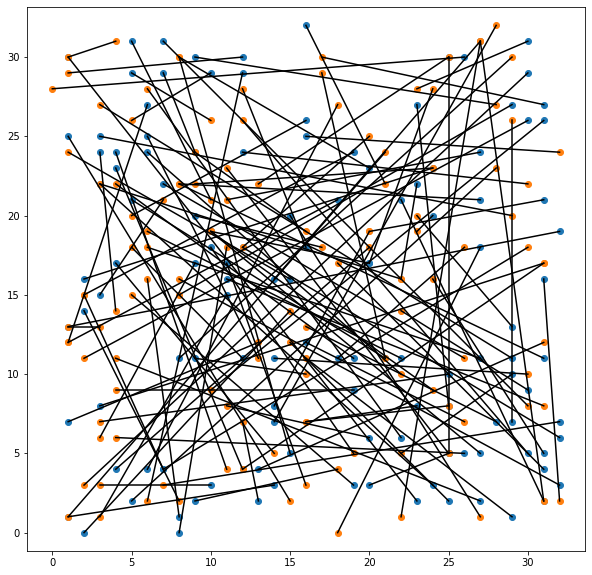

In [138]:
def generate_pairs_random():
    v1 = np.around(np.random.uniform(low = 0, high = DIM-1, size=(N_POINTS,2))).astype(int)
    v2 = np.around(np.random.uniform(low = 0, high = DIM-1, size=(N_POINTS,2))).astype(int)
    return np.array([[v1_,v2_] for v1_,v2_ in zip(v1,v2)])

a = generate_pairs_random()
x_1 = a[:,0,0]
y_1 = a[:,0,1]
x_2 = a[:,1,0]
y_2 = a[:,1,1]

plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

def connectpoints(x,y):
    plt.plot(x,y,'k-')

for x,y in zip(a[:,:,0], a[:,:,1]):
    connectpoints(x,y)

plt.axis('equal')
plt.show()

- generating x, y pairs where one point in the center and another on discreate position of polar grid

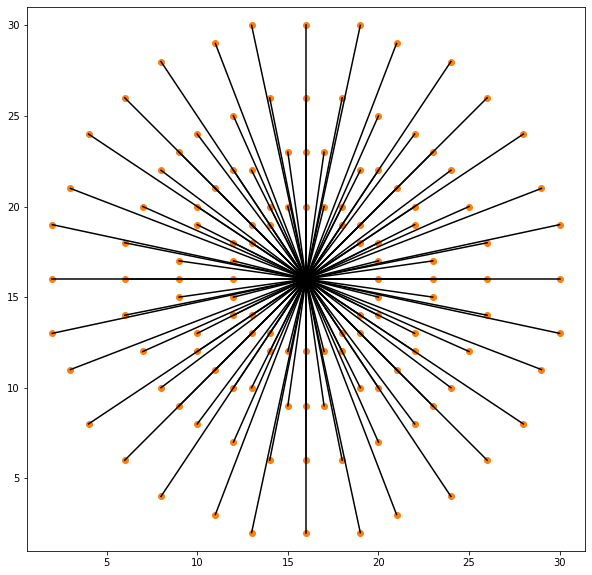

In [139]:
def pol2cart(rho, phi, lag = int((DIM-1)/2)):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return [int(round(x+lag)), int(round(y+lag))]

def generate_pairs_polar_circle(rho, n = 4):
    phi = 0
    res = []
    for i in range(int(N_POINTS/n)):
        res.append(pol2cart(rho, i/N_POINTS*n * 2*(math.pi)))
    return res

def generate_pairs_polar():
    res = []
    point = [int((DIM-1)/2),int((DIM-1)/2)]
    res+=[[point,p] for p in generate_pairs_polar_circle(4, n = 4)]
    res+=[[point,p] for p in generate_pairs_polar_circle(7, n = 4)]
    res+=[[point,p] for p in generate_pairs_polar_circle(10, n = 4)]
    res+=[[point,p] for p in generate_pairs_polar_circle(14, n = 4)]
    return np.array(res)

a = generate_pairs_polar()
x_1 = a[:,0,0]
y_1 = a[:,0,1]
x_2 = a[:,1,0]
y_2 = a[:,1,1]

plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

def connectpoints(x,y):
    plt.plot(x,y,'k-')

for x,y in zip(a[:,:,0], a[:,:,1]):
    connectpoints(x,y)

plt.axis('equal')
plt.show()

In [169]:
def get_cut_img(img, x, y):
    img_shape = img.shape
    dim = int((DIM-1)/2)
    if (x+dim>img_shape[0]-1) or (y+dim>img.shape[1]-1) or (x-dim<0) or (y-dim<0):
        return None
    else:
        return img[x-dim:x+dim+1, y-dim:y+dim+1]
    
def get_values(cut_img, points):
    return [[cut_img[tuple(p1)], cut_img[tuple(p2)]] for p1,p2 in points]

def get_binary(values):
    tmp = [i>j for i,j in values]
    return np.array(tmp, dtype = int)

def brief_descriptor(img, features, pattern = generate_pairs_random()):
    features_vectors = []
    for feat in features:
        cut_img = get_cut_img(img, feat[0], feat[1])
        if cut_img is None:
            features_vectors.append(np.zeros(N_POINTS))
        else:
            values = get_values(cut_img, pattern)
            features_vectors.append(get_binary(values))
    return features_vectors
        

/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in ubyte_scalars



Number of corner points:  32


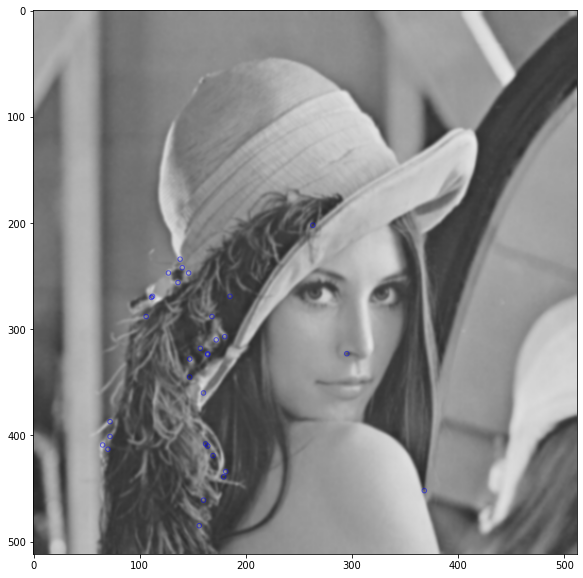

In [222]:
blur = cv2.GaussianBlur(img,(5,5),0)
corner_points = fast(blur)
corner_points = [list(c) for c in corner_points] # for plotting
rcParams['figure.figsize'] = 10, 10
print('Number of corner points: ', len(corner_points))
plt.imshow(cv2.cvtColor(blur, cv2.IMREAD_GRAYSCALE))
plt.scatter(np.array(corner_points)[:,1], np.array(corner_points)[:,0], s = 20, alpha=0.5, edgecolors='b', color = 'none')
plt.show()

In [226]:
# getting vector for each keypoint (using random pairs)
pattern = generate_pairs_random()
res = brief_descriptor(img, corner_points, pattern = pattern)
res[:5]

[array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]),
 array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]),
 array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,

In [225]:
# getting vector for each keypoint (using not random polar pairs)
res = brief_descriptor(img, corner_points, pattern = generate_pairs_polar())
res[:5]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

**Коментар:** Як ми можемо спостерігати - вектори досить відрізняються у двох підходах.

# Спроба протестувати дескриптори

/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in ubyte_scalars



Number of corner points:  44


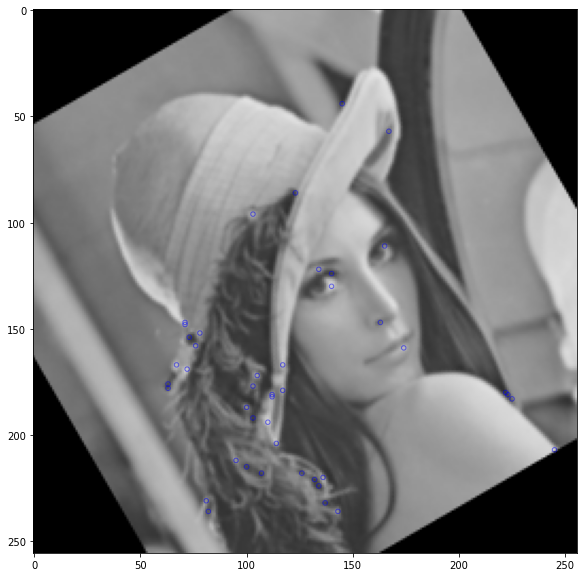

In [251]:
test_image = cv2.pyrDown(blur)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

corner_points_2 = fast(test_image)
corner_points_2 = [list(c) for c in corner_points_2] # for plotting

print('Number of corner points: ', len(corner_points_2))

plt.imshow(cv2.cvtColor(test_image, cv2.IMREAD_GRAYSCALE))
plt.scatter(np.array(corner_points_2)[:,1], np.array(corner_points_2)[:,0], s = 20, alpha=0.5, edgecolors='b', color = 'none')
plt.show()


In [252]:
res_2 = brief_descriptor(test_image, corner_points_2, pattern = pattern)

In [253]:
# define hamming distance to compare binary vectors
from scipy.spatial import distance
def ham_dist(x,y):
    return distance.hamming(x,y)

In [254]:
def get_neibour(set_1, set_2, index_1, k=5):
    v1 = set_1[index_1]
    dists = [ham_dist(v1,v) for v in set_2]
    return np.argpartition(dists, k)[:k]

## plotting results of investigation

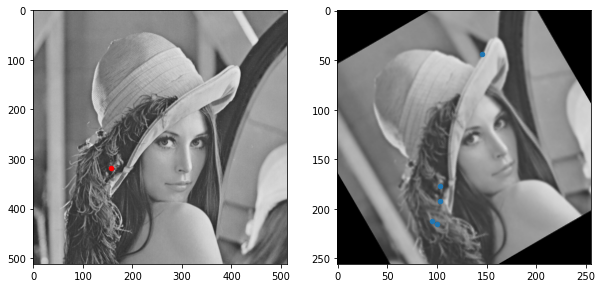

In [263]:
import matplotlib.cm as cm
f, axarr = plt.subplots(1,2)

index = 13

val = np.array(corner_points[index])
test = np.array([corner_points_2[i] for i in get_neibour(res, res_2, index)])

x_1 = [val[1]]
y_1 = [val[0]]
x_2 = test[:,1]
y_2 = test[:,0]

# colors = cm.rainbow(np.linspace(0, 1, len(val)))

axarr[0].imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))
axarr[1].imshow(cv2.cvtColor(test_image, cv2.IMREAD_GRAYSCALE))

axarr[0].scatter(x_1, y_1, s = 20, alpha=1, c = 'r')
axarr[1].scatter(x_2, y_2, s = 20, alpha=1)

plt.show()